# RBM sobre MNIST

Entrenamos una máquina restringida de Boltzmann siguiendo la idea de Hinton & Salakhutdinov (2006) para reconstruir imágenes 28x28 de MNIST.


In [20]:
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from typing import Tuple
from pathlib import Path
np.random.seed(42)


## Carga y preparación de los datos

Leemos los archivos `.pt` provistos (guardados como zip) y normalizamos los píxeles a `[0, 1]`.


In [21]:

DATA_DIR = Path('TP2/ejercicio-6')
if not DATA_DIR.exists():
    DATA_DIR = Path('../ejercicio-6')

def load_mnist_from_pt(data_zip: Path, labels_zip: Path) -> Tuple[np.ndarray, np.ndarray]:
    with zipfile.ZipFile(data_zip) as zd:
        raw_images = zd.read('MNIST_train_data/data/0') if 'training' in data_zip.name else zd.read('MNIST_test_data/data/0')
    with zipfile.ZipFile(labels_zip) as zl:
        raw_labels = zl.read('MNIST_train_labels/data/0') if 'training' in labels_zip.name else zl.read('MNIST_test_labels/data/0')
    images = np.frombuffer(raw_images, dtype=np.uint8).reshape(-1, 28 * 28)
    labels = np.frombuffer(raw_labels, dtype='<i8')
    return images, labels

train_images, train_labels = load_mnist_from_pt(DATA_DIR / 'MNIST_training_data.pt', DATA_DIR / 'MNIST_training_labels.pt')
test_images, test_labels = load_mnist_from_pt(DATA_DIR / 'MNIST_test_data.pt', DATA_DIR / 'MNIST_test_labels.pt')
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0
print(train_images.shape, test_images.shape)



(60000, 784) (10000, 784)


In [22]:

n_train = 10000
n_test = 2000
subset_idx = np.random.choice(len(train_images), size=n_train, replace=False)
train_data = train_images[subset_idx]
train_targets = train_labels[subset_idx]
test_data = test_images[:n_test]
test_targets = test_labels[:n_test]
print(train_data.shape, test_data.shape)



(10000, 784) (2000, 784)


## Implementación de la RBM

In [23]:

class RBM:
    def __init__(self, n_visible: int, n_hidden: int, learning_rate: float = 0.1, momentum: float = 0.5, weight_decay: float = 0.0002):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.W = 0.01 * np.random.randn(n_visible, n_hidden)
        self.visible_bias = np.zeros(n_visible)
        self.hidden_bias = np.zeros(n_hidden)
        self.delta_W = np.zeros_like(self.W)
        self.delta_vb = np.zeros_like(self.visible_bias)
        self.delta_hb = np.zeros_like(self.hidden_bias)

    @staticmethod
    def sigmoid(x):
        return 1.0 / (1.0 + np.exp(-x))

    def sample_hidden(self, v):
        probs = self.sigmoid(v @ self.W + self.hidden_bias)
        return probs, (np.random.rand(*probs.shape) < probs).astype(np.float32)

    def sample_visible(self, h):
        probs = self.sigmoid(h @ self.W.T + self.visible_bias)
        return probs, (np.random.rand(*probs.shape) < probs).astype(np.float32)

    def contrastive_divergence(self, v0):
        ph_mean, ph_sample = self.sample_hidden(v0)
        pv_mean, pv_sample = self.sample_visible(ph_sample)
        nh_mean, _ = self.sample_hidden(pv_sample)
        batch_size = v0.shape[0]
        dW = (v0.T @ ph_mean - pv_sample.T @ nh_mean) / batch_size - self.weight_decay * self.W
        dvb = np.mean(v0 - pv_sample, axis=0)
        dhb = np.mean(ph_mean - nh_mean, axis=0)
        self.delta_W = self.momentum * self.delta_W + self.learning_rate * dW
        self.delta_vb = self.momentum * self.delta_vb + self.learning_rate * dvb
        self.delta_hb = self.momentum * self.delta_hb + self.learning_rate * dhb
        self.W += self.delta_W
        self.visible_bias += self.delta_vb
        self.hidden_bias += self.delta_hb
        return pv_mean

    def reconstruct(self, v):
        h_mean = self.sigmoid(v @ self.W + self.hidden_bias)
        v_mean = self.sigmoid(h_mean @ self.W.T + self.visible_bias)
        return v_mean

    def reconstruction_error(self, data):
        recon = self.reconstruct(data)
        return np.mean((data - recon) ** 2)



## Entrenamiento y seguimiento del error


In [24]:

rbm = RBM(n_visible=784, n_hidden=128, learning_rate=0.08, momentum=0.5, weight_decay=0.0001)
epochs = 15
batch_size = 64
train_errors = []
eval_errors = []
for epoch in range(1, epochs + 1):
    perm = np.random.permutation(len(train_data))
    batches = len(train_data) // batch_size
    for i in range(batches):
        batch_idx = perm[i * batch_size:(i + 1) * batch_size]
        batch = train_data[batch_idx]
        rbm.contrastive_divergence(batch)
    train_err = rbm.reconstruction_error(train_data[:2000])
    eval_err = rbm.reconstruction_error(test_data[:2000])
    train_errors.append(train_err)
    eval_errors.append(eval_err)
    print(f"Epoch {epoch:02d} - train MSE {train_err:.4f} - eval MSE {eval_err:.4f}")



Epoch 01 - train MSE 0.0342 - eval MSE 0.0335
Epoch 02 - train MSE 0.0265 - eval MSE 0.0260
Epoch 03 - train MSE 0.0229 - eval MSE 0.0225
Epoch 04 - train MSE 0.0208 - eval MSE 0.0207
Epoch 05 - train MSE 0.0192 - eval MSE 0.0190
Epoch 06 - train MSE 0.0180 - eval MSE 0.0178
Epoch 07 - train MSE 0.0171 - eval MSE 0.0170
Epoch 08 - train MSE 0.0165 - eval MSE 0.0163
Epoch 09 - train MSE 0.0158 - eval MSE 0.0158
Epoch 10 - train MSE 0.0152 - eval MSE 0.0153
Epoch 11 - train MSE 0.0148 - eval MSE 0.0148
Epoch 12 - train MSE 0.0144 - eval MSE 0.0145
Epoch 13 - train MSE 0.0141 - eval MSE 0.0142
Epoch 14 - train MSE 0.0137 - eval MSE 0.0138
Epoch 15 - train MSE 0.0134 - eval MSE 0.0135


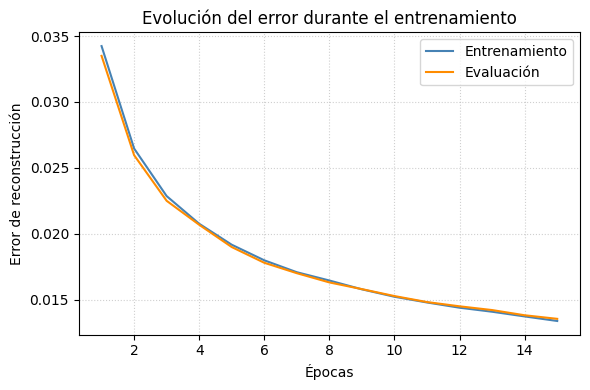

In [ ]:

plt.figure(figsize=(6, 4))
plt.plot(range(1, epochs + 1), train_errors, label='Entrenamiento', color='steelblue')
plt.plot(range(1, epochs + 1), eval_errors, label='Evaluación', color='darkorange')
plt.xlabel('Épocas')
# Error cuadrático medido
plt.ylabel('Error de reconstrucción')
plt.title('Evolución del error durante el entrenamiento')
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig('/home/camila/Documents/Redes Neuronales/Redes-Neuronales/TP2/ejercicio-5/error-reconstruccion-rbm.png', dpi=150, bbox_inches='tight')
plt.show()



## Reconstrucciones ejemplo

Mostramos un ejemplo por dígito (fila superior: original, inferior: reconstrucción).


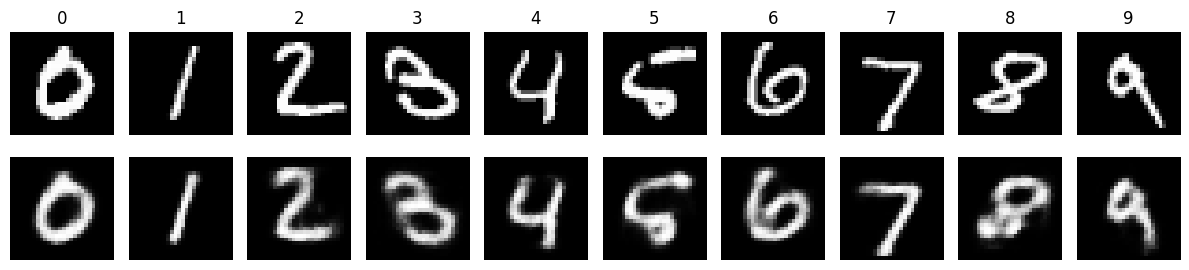

In [26]:

def plot_reconstructions(model: RBM, data: np.ndarray, labels: np.ndarray, save_path: str = None):
    fig, axes = plt.subplots(2, 10, figsize=(12, 3))
    for digit in range(10):
        idx = np.where(labels == digit)[0][0]
        original = data[idx]
        recon = model.reconstruct(original.reshape(1, -1))[0]
        axes[0, digit].imshow(original.reshape(28, 28), cmap='gray')
        axes[0, digit].axis('off')
        axes[0, digit].set_title(str(digit))
        axes[1, digit].imshow(recon.reshape(28, 28), cmap='gray')
        axes[1, digit].axis('off')
    axes[0, 0].set_ylabel('Original', rotation=90, size=12)
    axes[1, 0].set_ylabel('Reconstruida', rotation=90, size=12)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

plot_reconstructions(rbm, test_data, test_targets, save_path='/home/camila/Documents/Redes Neuronales/Redes-Neuronales/TP2/ejercicio-5/ejemplos-reconstruidos-2.png')

